In [68]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sklearn
import tensorflow as tf

import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('poster')

## Load and process the data

In [69]:
data = np.loadtxt('data/train.csv', delimiter=',', skiprows=1)
images_submission = np.loadtxt('data/test.csv', delimiter=',', skiprows=1)
images = data[:, 1:]
labels = data[:, 0]
del data

In [70]:
images_submission.shape

(28000, 784)

In [71]:
images.shape[1]

784

In [72]:
image_pixels = 784
image_height = image_width = 28
num_channels = 1  # grayscale

In [73]:
np.unique(labels, return_counts=True)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.]),
 array([4132, 4684, 4177, 4351, 4072, 3795, 4137, 4401, 4063, 4188]))

In [74]:
num_classes = 10

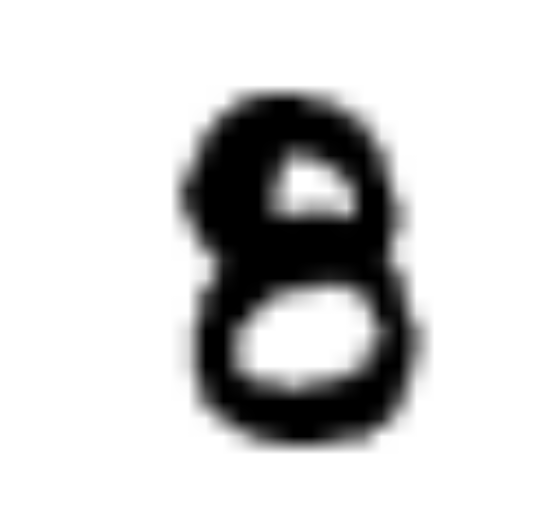

8.0


In [75]:
idx = 23009
test_image = images[idx, :]
test_label = labels[idx]
plt.axis('off')
img = test_image.reshape(28, 28)
plt.imshow(img, cmap=cm.binary)
plt.show()
print(test_label)

In [76]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.cross_validation import train_test_split

labelEncoder = OneHotEncoder(sparse=False)

def processData(images, labels):
    # Normalize pixel values
    images = images / 255
    images = images.reshape((-1, image_height, image_width, num_channels)).astype(np.float32)
    labels = labelEncoder.fit_transform(labels.reshape(-1,1)).astype(np.float32)
    return images, labels

images_train, images_test, labels_train, labels_test = train_test_split(images, labels,
                                                                        test_size=0.20)
images_train, images_valid, labels_train, labels_valid = train_test_split(images_train,
                                                                          labels_train,
                                                                          test_size=0.20)

images_train, labels_train = processData(images_train, labels_train)
images_valid, labels_valid = processData(images_valid, labels_valid)
images_test, labels_test = processData(images_test, labels_test)
images_all, labels_all = processData(images, labels)
images_sub, _ = processData(images_submission, labels_train)

print('Total set: ', images_all.shape, labels_all.shape)
print('Training set: ', images_train.shape, labels_train.shape)
print('Validation set: ', images_valid.shape, labels_valid.shape)
print('Test set: ', images_test.shape, labels_test.shape)
print('Submission set: ', images_sub.shape)

Total set:  (42000, 28, 28, 1) (42000, 10)
Training set:  (26880, 28, 28, 1) (26880, 10)
Validation set:  (6720, 28, 28, 1) (6720, 10)
Test set:  (8400, 28, 28, 1) (8400, 10)
Submission set:  (28000, 28, 28, 1)


## Build the computation graph

In [77]:
batch_size = 50
patch_size = 5
depth = 32
num_hidden = 1024
keep_prob = 0.5
learning_rate = .0001

graph = tf.Graph()

with graph.as_default():
    
    # Input data
    tf_images_train = tf.placeholder(tf.float32, shape=(batch_size, image_height, image_width,
                                                        num_channels))
    tf_labels_train = tf.placeholder(tf.float32, shape=(batch_size, num_classes))
    tf_images_valid = tf.constant(images_valid)
    tf_labels_valid = tf.constant(labels_valid)
    tf_images_test = tf.constant(images_test)
    tf_images_sub = tf.placeholder(tf.float32, shape=(100, image_height, image_width,
                                                        num_channels))
    
    # Variables
    # First convolutional layer weights and biases
    conv1_W = tf.Variable(tf.truncated_normal(shape=[patch_size,
                                                     patch_size,
                                                     num_channels,
                                                     depth], stddev=0.1))
    conv1_b = tf.Variable(tf.zeros(shape=[depth]))
                          
    # Second convolutional layer weights and biases
    conv2_W = tf.Variable(tf.truncated_normal(shape=[patch_size,
                                                     patch_size,
                                                     depth,
                                                     depth*2], stddev=0.1))
    conv2_b = tf.Variable(tf.constant(0.1, shape=[depth*2]))
    
    # First fully connected hidden layer weights and biases
    fc1_W = tf.Variable(tf.truncated_normal(shape=[image_height // 4 * image_width // 4 \
                                                   * depth*2,
                                                   num_hidden], stddev=0.1))
    fc1_b = tf.Variable(tf.constant(0.1, shape=[num_hidden]))
    
    # Readout fully connected layer weights and biases
    W = tf.Variable(tf.truncated_normal(shape=[num_hidden, num_classes], stddev=0.1))
    b = tf.Variable(tf.constant(0.1, shape=[num_classes]))
    
    # Model
    def model(images, training=True):
        # First conv layer
        conv1 = tf.nn.conv2d(images, conv1_W, strides=[1, 1, 1, 1], padding='SAME')
        h_conv1 = tf.nn.relu(conv1 + conv1_b)
    
        # First pooling layer
        h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                                 padding='SAME')
        
        # Second conv layer
        conv2 = tf.nn.conv2d(h_pool1, conv2_W, strides=[1, 1, 1, 1], padding='SAME')
        h_conv2 = tf.nn.relu(conv2 + conv2_b)
        
        # Second pooling layer
        h_pool2 = tf.nn.max_pool(h_conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                                 padding='SAME')
        
        # Reshape for fully connected layers ie. flatten the second pooling layer
        sh = h_pool2.get_shape().as_list()
        h_pool2_flat = tf.reshape(h_pool2, [sh[0], np.product(sh[1:])])
        
        # First fully connected hidden layer
        fc1 = tf.matmul(h_pool2_flat, fc1_W)
        h_fc1 = tf.nn.relu(fc1 + fc1_b)
        
        # Dropout only when training
        kp = keep_prob if training else 1
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob=kp)
        
        # Readout layer
        logits = tf.matmul(h_fc1_drop, W) + b
        
        return logits
    
    # Loss
    def loss(images, labels, training=True):
        logits = model(images, training)
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, labels)
        loss = tf.reduce_mean(cross_entropy)
        return loss
    
    # Optimization
    loss_train = loss(tf_images_train, tf_labels_train)
    loss_valid = loss(tf_images_valid, tf_labels_valid, training=False)
    trainStep = tf.train.AdamOptimizer(learning_rate).minimize(loss_train)
    
    # Predictions
    train_pred = tf.nn.softmax(model(tf_images_train, training=False))
    valid_pred = tf.nn.softmax(model(tf_images_valid, training=False))
    test_pred = tf.nn.softmax(model(tf_images_test, training=False))
    sub_pred = tf.nn.softmax(model(tf_images_sub, training=False))

### Some helper functions

In [78]:
offset = 0
epochs = 0
num_examples = images_train.shape[0]

# Return training data in batches of batch_size, shuffle training data after each epoch
def getBatches(batch_size):
    
    global images_train
    global labels_train
    global offset
    global epochs
    
    start_idx = offset
    offset += batch_size
    
    if offset > num_examples:
        # 1 epoch completed
        epochs += 1
        # Reshuffle the training data
        shuffled_idxs = np.random.permutation(num_examples)
        images_train = images_train[shuffled_idxs]
        labels_train = labels_train[shuffled_idxs]
        start_idx = 0
        offset = batch_size
    images = images_train[start_idx:offset, :, :, :]
    labels = labels_train[start_idx:offset, :]
    return images, labels

def acc(pred, labels):
    acc = np.mean(np.equal(np.argmax(pred, axis=1), np.argmax(labels, axis=1)))
    return acc * 100

## Build a session to train the model in batches

In [83]:
num_steps = 7000
train_loss = []
valid_loss = []
submission_pred = np.zeros(len(images_sub))

with tf.Session(graph=graph) as sess:
    tf.initialize_all_variables().run()
    print('Initialized')
    
    for step in range(num_steps+1):
        # Get batch input data
        batch_images, batch_labels = getBatches(batch_size)
        
        # Fill the feed_dict
        feed_dict = {tf_images_train: batch_images,
                     tf_labels_train: batch_labels}
        
        # Run training computations
        _, l = sess.run([trainStep, loss_train], feed_dict = feed_dict)
        
        # Show training progress
        if (step % 100 == 0):
            vloss = loss_valid.eval()
            train_loss.append(l)
            valid_loss.append(vloss)
            if (step % 500 == 0):
                print('Step: {:d}   Training Loss: {:03.2f} Validation Loss: {:03.2f}'
                      .format(step, l, vloss))
    print('VALIDATION ACCURACY: {:3.3f}'.format(acc(valid_pred.eval(), labels_valid)))
    print('TEST ACCURACY: {:3.3f}'.format(acc(test_pred.eval(), labels_test)))
    # Evaluate on submission images
    for start in range(0, len(images_sub), 100):
        sub_batch = images_sub[start:start+100, :, :, :]
        sub = sess.run([sub_pred], feed_dict={tf_images_sub : sub_batch})
        submission_pred[start:start+100] = np.argmax(sub[0], axis=1)
        

Initialized
Step: 0   Training Loss: 7.97 Validation Loss: 3.72
Step: 500   Training Loss: 0.42 Validation Loss: 0.20
Step: 1000   Training Loss: 0.09 Validation Loss: 0.13
Step: 1500   Training Loss: 0.11 Validation Loss: 0.10
Step: 2000   Training Loss: 0.14 Validation Loss: 0.07
Step: 2500   Training Loss: 0.12 Validation Loss: 0.06
Step: 3000   Training Loss: 0.03 Validation Loss: 0.05
Step: 3500   Training Loss: 0.01 Validation Loss: 0.04
Step: 4000   Training Loss: 0.06 Validation Loss: 0.04
Step: 4500   Training Loss: 0.02 Validation Loss: 0.03
Step: 5000   Training Loss: 0.02 Validation Loss: 0.03
Step: 5500   Training Loss: 0.01 Validation Loss: 0.03
Step: 6000   Training Loss: 0.03 Validation Loss: 0.02
Step: 6500   Training Loss: 0.02 Validation Loss: 0.02
Step: 7000   Training Loss: 0.02 Validation Loss: 0.02
VALIDATION ACCURACY: 99.301
TEST ACCURACY: 99.464


In [84]:
np.unique(submission_pred, return_counts=True)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.]),
 array([2771, 3203, 2823, 2797, 2739, 2489, 2754, 2895, 2765, 2764]))

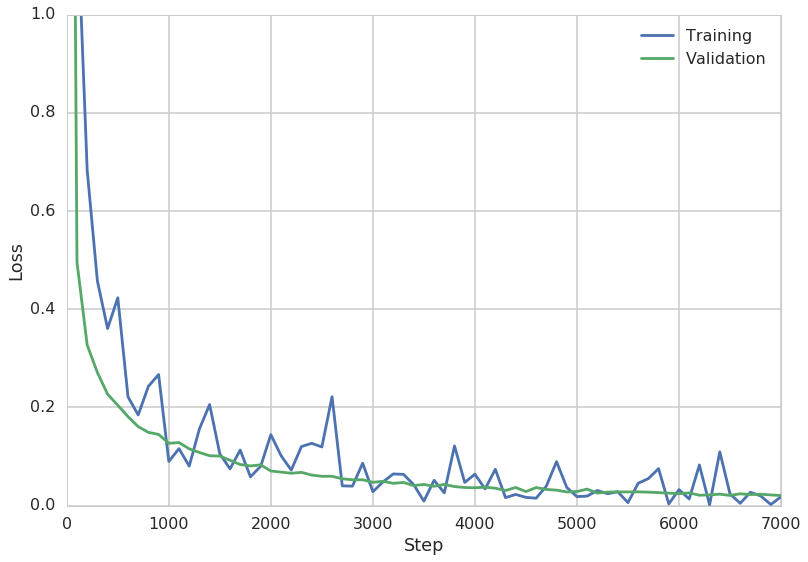

In [87]:
x_range = (range(0, len(train_loss)*100, 100))
plt.plot(x_range, train_loss, label='Training')
plt.plot(x_range, valid_loss, label='Validation')
plt.legend()
plt.ylim(ymax=1)
plt.ylabel('Loss')
plt.xlabel('Step')
plt.show()

### Create a submission file

In [86]:
np.savetxt('result/result.csv',
            np.c_[range(1, len(images_sub)+1),submission_pred],
            delimiter=',',
            header='ImageId,Label',
            comments='',
            fmt='%d')